In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
#from utils import *
from matplotlib import rc
mpl.rcParams['font.size'] = 16

# Q1 
### Q1.1 Visualise the distribution of degree classifications in different providers

In this section we explore the distribution of degree classifications in different providers.  

First we get the data from the website (https://www.hesa.ac.uk/data-and-analysis/students/outcomes).

In [3]:
degree_classifications_2019 = pd.read_csv('datasets/2019-2020.csv')
degree_classifications_2019.dropna(inplace=True)
degree_classifications_2019['UKPRN'] = degree_classifications_2019['UKPRN'].astype('int64')

After looking through the data, we find that numeric data are actually represented as strings instead of integers. Hence we will first change the type of data from string to integer.

In [4]:
def parse(int_string):
    total = 0  # The resulting value
    cur = 1    # Current parse position
    for i in range(len(int_string)):
        if int_string[-1-i] != ',':  # Identify commas
            total += cur * int(int_string[-1-i])
            cur *= 10
    return total

for i in degree_classifications_2019.columns[2:]:
    if i != 'Third class honours/Pass':
        integer_list = list(map(parse, degree_classifications_2019[i]))
        degree_classifications_2019[i] = integer_list

Some HE providers have very small number of total degress placed, hence we only choose those who have issued more than 1000 first degrees.

In [5]:
degree_classifications_2019 = degree_classifications_2019.loc[degree_classifications_2019['First degree'] > 1000]

In [6]:
# Produce the fraction of degrees of the degree classification
fraction_2019 = degree_classifications_2019.copy()

for i in degree_classifications_2019.columns[2:-1]:
    fraction_2019[i] = fraction_2019[i] / fraction_2019['First degree']

fraction_2019 = fraction_2019.sort_values('First class honours', ascending=False)

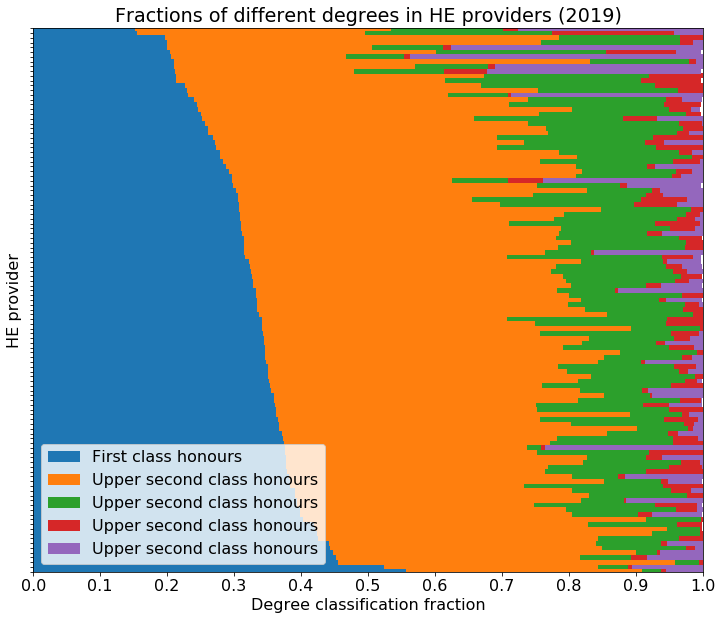

In [7]:
fig,ax = plt.subplots(figsize=(12,10))
# Plot stacked bars
ax.barh(fraction_2019['HE provider'], fraction_2019['First class honours'], height=1.0, label='First class honours')
ax.barh(fraction_2019['HE provider'], fraction_2019['Upper second class honours'], left=fraction_2019['First class honours'], height=1.0, label='Upper second class honours')
ax.barh(fraction_2019['HE provider'], fraction_2019['Lower second class honours'], left=fraction_2019['First class honours']+fraction_2019['Upper second class honours'], height=1.0, label='Upper second class honours')
ax.barh(fraction_2019['HE provider'], fraction_2019['Third class honours/Pass'], left=fraction_2019['First class honours']+fraction_2019['Upper second class honours']+fraction_2019['Lower second class honours'], height=1.0, label='Upper second class honours')
ax.barh(fraction_2019['HE provider'], fraction_2019['Unclassified'], left=fraction_2019['First class honours']+fraction_2019['Upper second class honours']+fraction_2019['Lower second class honours']+fraction_2019['Third class honours/Pass'], height=1.0, label='Upper second class honours')
ax.set_yticklabels([])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_ylabel("HE provider")
ax.set_xlabel("Degree classification fraction")
ax.set_ylim([0,len(degree_classifications_2019)-1])
ax.set_xlim([0,1])
ax.set_title("Fractions of different degrees in HE providers (2019)")
plt.legend()
plt.show()

Below generates the table with the highest fraction of different degree classifications in 2019-2020. The 3 highest HE providers of each degree classification is provided

In [8]:
max_table = pd.DataFrame(columns=fraction_2019.columns[2:-1])
for degree in fraction_2019.columns[2:-1]:
    degree_sorted = fraction_2019.sort_values(degree)
    max_table[degree] = list(degree_sorted['HE provider'][-3:])
max_table

,First class honours,Upper second class honours,Lower second class honours,Third class honours/Pass,Unclassified
0,London School of Economics and Political Science,The University of Chichester,BIMM Limited,University of Bedfordshire,Robert Gordon University
1,"Imperial College of Science, Technology and Me...",The University of Winchester,The Open University,Buckinghamshire New University,The University of Dundee
2,University College London,Bath Spa University,University of Bedfordshire,The Open University,The University of the West of Scotland


Below generates the table with the lowest fraction of different degree classifications in 2019-2020. The 3 lowest HE providers of each degree classification is provided

In [9]:
min_table = pd.DataFrame(columns=fraction_2019.columns[2:-1])
for degree in fraction_2019.columns[2:-1]:
    degree_sorted = fraction_2019.sort_values(degree)
    min_table[degree] = list(degree_sorted['HE provider'][:3])
min_table

,First class honours,Upper second class honours,Lower second class honours,Third class honours/Pass,Unclassified
0,The University of Stirling,The University of the West of Scotland,The University of Cambridge,Royal Holloway and Bedford New College,University of Wales Trinity Saint David
1,The Open University,Robert Gordon University,University College London,The University of Edinburgh,Aberystwyth University
2,The University of Winchester,The University of Dundee,The University of Oxford,The University of Glasgow,Teesside University


Here is a map showing locations of HE providers with different first class honours fractions. The heatmap color shows where this fraction is high and where this fraction is low.

In [10]:
# get latitude and longitude
uni_location = pd.read_csv('datasets/LOCATION.csv')
uni_location_lat = [uni_location[uni_location['UKPRN'] == UKPRN_number].iloc[0]['LATITUDE'] for UKPRN_number in list(fraction_2019['UKPRN'])]
uni_location_long = [uni_location[uni_location['UKPRN'] == UKPRN_number].iloc[0]['LONGITUDE'] for UKPRN_number in list(fraction_2019['UKPRN'])]
# Plot the Map
map_UK = folium.Map(location=[54.5074, -5.0], zoom_start = 6) # for UK 
uni_location_data = [[tup[0], tup[1], tup[2]] for tup in zip(uni_location_lat, uni_location_long, list(fraction_2019['First class honours']))]
heatmap_UK = plugins.HeatMap(uni_location_data, min_opacity=0.4)
heatmap_UK.add_to(folium.FeatureGroup(name='Heat Map').add_to(map_UK))
folium.LayerControl().add_to(map_UK)
map_UK

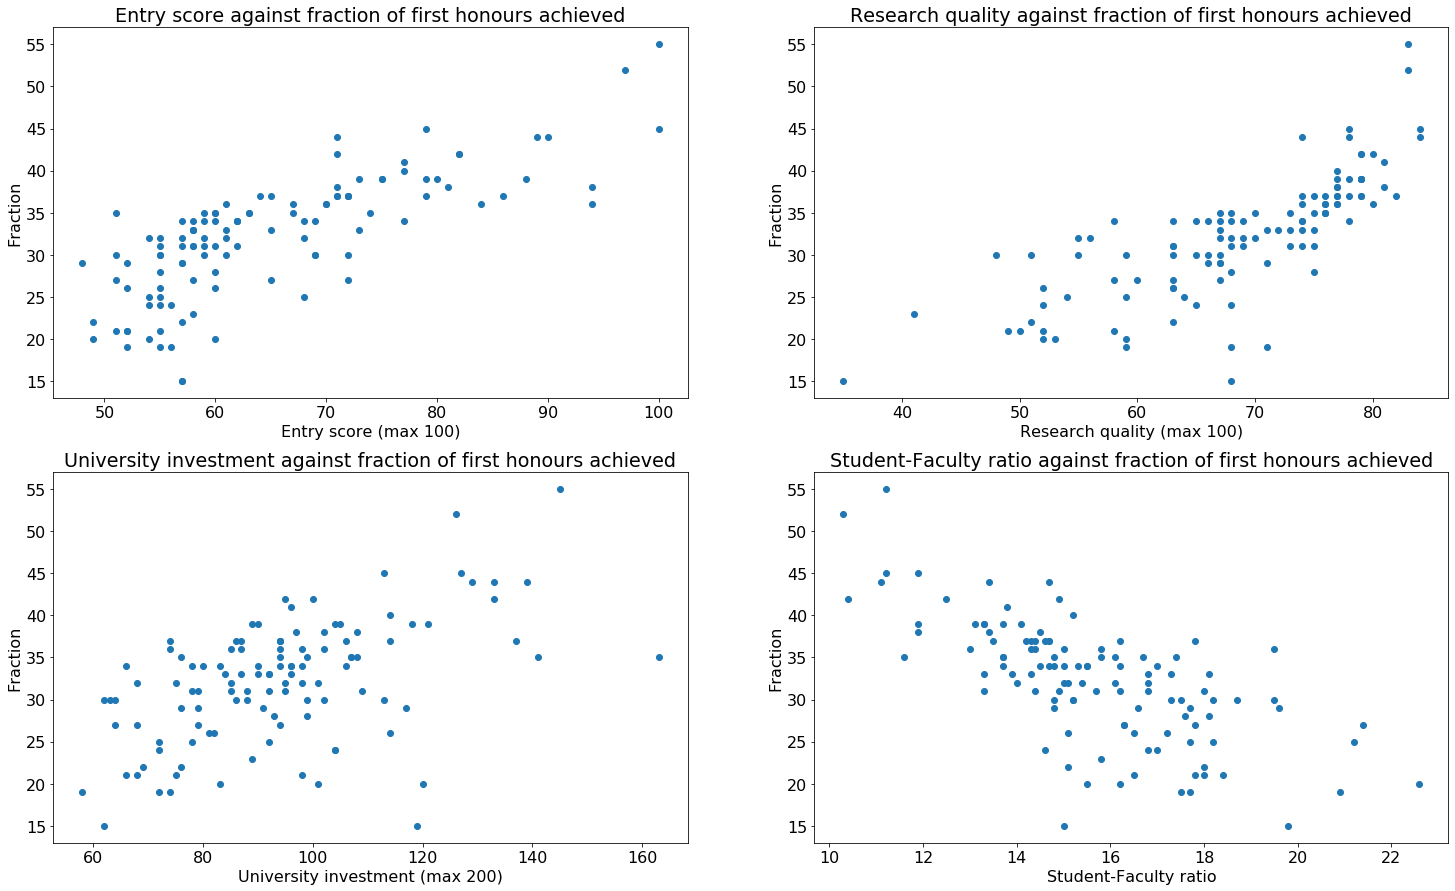

In [11]:
def occurs(target, list):
    for item in list:
        if item in target or target in item:
            return list.index(item) + 1
    return False

ranking_file = open('datasets/ranking.txt','r')
entry_file = open('datasets/entry.txt','r')
research_file = open('datasets/research.txt','r')
academic_file = open('datasets/academic_investment.txt','r')
facilities_file = open('datasets/facilities_investment.txt', 'r')
faculty_student_ratio_file = open('datasets/student_faculty_ratio.txt', 'r')
# read data
university_ranking = list(map(lambda x: x[:-1], ranking_file.readlines()))
entry_score = list(map(lambda x: int(x[:-2]), entry_file.readlines()))
research_score = list(map(lambda x: int(x[:-2]), research_file.readlines()))
academic_score = list(map(lambda x: int(x[:-2]), academic_file.readlines()))
facilities_score = list(map(lambda x: int(x[:-2]), facilities_file.readlines()))
ratio_score = list(map(lambda x: float(x[:-1]), faculty_student_ratio_file.readlines()))
investment_score = [a+f for a,f in zip(academic_score, facilities_score)]
# Create dataframes for reading in the data

fraction_in_percentage = list(map(lambda x: int(x*100), fraction_2019['First class honours']))
entry_data = pd.DataFrame({'Fraction': fraction_in_percentage, 'Score': list(map(lambda x: x[0], zip(entry_score, fraction_in_percentage)))})
research_data = pd.DataFrame({'Fraction': fraction_in_percentage, 'Score': list(map(lambda x: x[0], zip(research_score, fraction_in_percentage)))})
academic_data = pd.DataFrame({'Fraction': fraction_in_percentage, 'Score': list(map(lambda x: x[0], zip(investment_score, fraction_in_percentage)))})
ratio_data = pd.DataFrame({'Fraction': fraction_in_percentage, 'Score': list(map(lambda x: x[0], zip(ratio_score, fraction_in_percentage)))})

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(25,15))
ax1.scatter(entry_data['Score'], entry_data['Fraction'])
ax2.scatter(research_data['Score'], research_data['Fraction'])
ax3.scatter(academic_data['Score'], academic_data['Fraction'])
ax4.scatter(ratio_data['Score'], ratio_data['Fraction'])
# Title
ax1.set_title('Entry score against fraction of first honours achieved')
ax2.set_title('Research quality against fraction of first honours achieved')
ax3.set_title('University investment against fraction of first honours achieved')
ax4.set_title('Student-Faculty ratio against fraction of first honours achieved')
# x label
ax1.set_xlabel('Entry score (max 100)')
ax2.set_xlabel('Research quality (max 100)')
ax3.set_xlabel('University investment (max 200)')
ax4.set_xlabel('Student-Faculty ratio')
# y label
ax1.set_ylabel('Fraction')
ax2.set_ylabel('Fraction')
ax3.set_ylabel('Fraction')
ax4.set_ylabel('Fraction')
plt.show()

# Q4

In [12]:
england = pd.read_csv('datasets/England.csv')
northern_ireland = pd.read_csv('datasets/Northern_Ireland.csv')
scotland = pd.read_csv('datasets/Scotland.csv')
wales = pd.read_csv('datasets/Wales.csv')

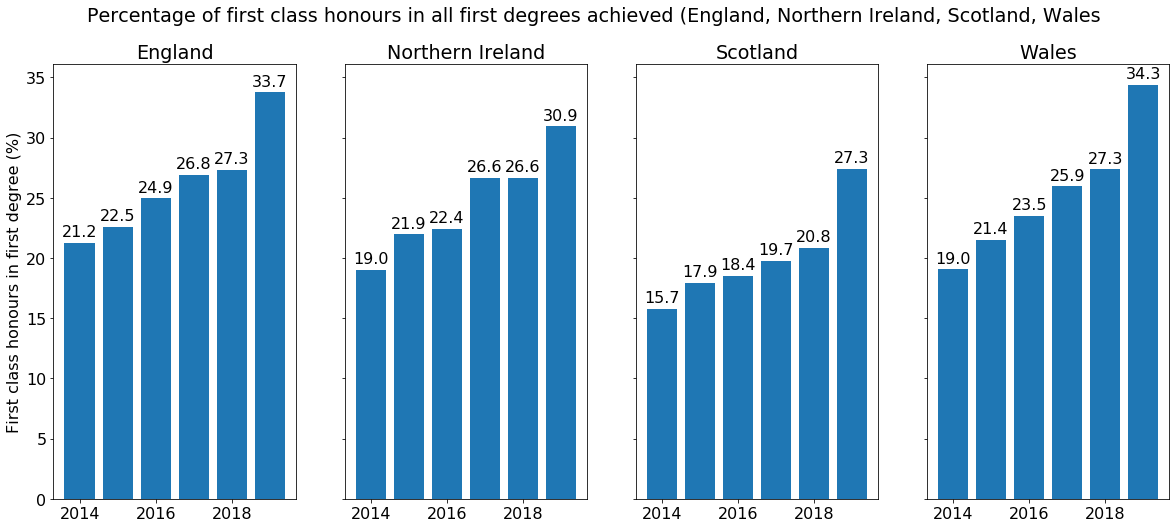

In [13]:
def annotate(axes,labels):
    rects = axes.patches
    for rect,label in zip(rects,labels):
        height = rect.get_height()
        axes.text(rect.get_x() + rect.get_width() / 2, height + 0.3, str(label)[:4] ,ha='center', va='bottom')

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,8),sharey=True)
ax1.bar(range(2014,2020), england['First class honours'] / england['Total'] * 100)
ax1.set_title('England')
ax1.set_ylabel('First class honours in first degree (%)')
ax2.bar(range(2014,2020), northern_ireland['First class honours'] / northern_ireland['Total'] * 100)
ax2.set_title('Northern Ireland')
ax3.bar(range(2014,2020), scotland['First class honours'] / scotland['Total'] * 100)
ax3.set_title('Scotland')
ax4.bar(range(2014,2020), wales['First class honours'] / wales['Total'] * 100)
ax4.set_title('Wales')
annotate(ax1, england['First class honours'] / england['Total'] * 100)
annotate(ax2, northern_ireland['First class honours'] / northern_ireland['Total'] * 100)
annotate(ax3, scotland['First class honours'] / scotland['Total'] * 100)
annotate(ax4, wales['First class honours'] / wales['Total'] * 100)
plt.suptitle('Percentage of first class honours in all first degrees achieved (England, Northern Ireland, Scotland, Wales')
plt.show()

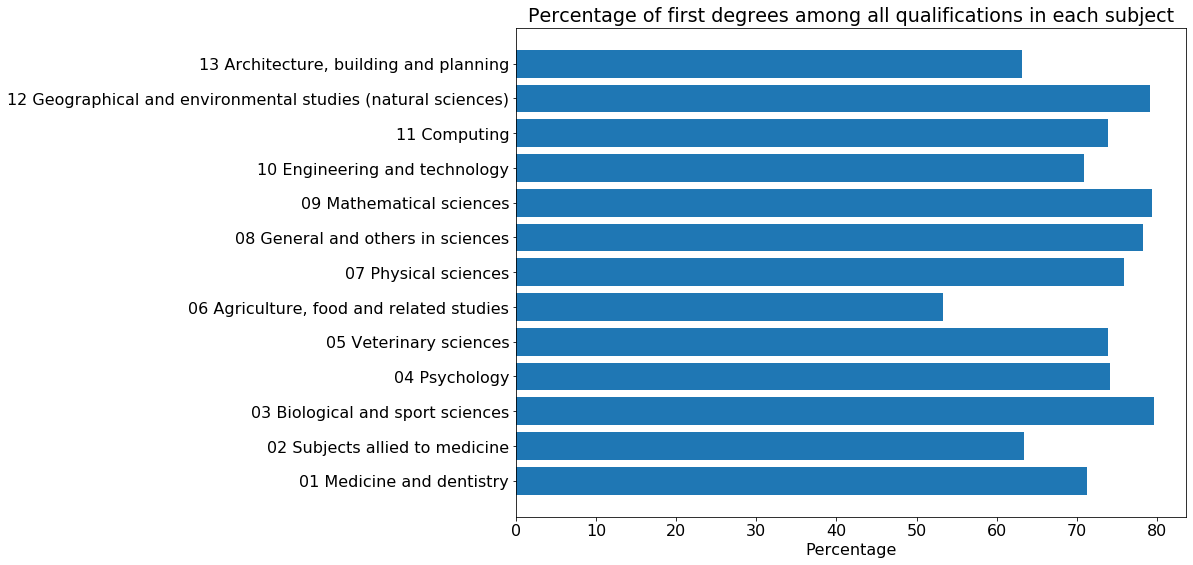

In [14]:
def parse(int_string):
    total = 0  # The resulting value
    cur = 1    # Current parse position
    for i in range(len(int_string)):
        if int_string[-1-i] != ',':  # Identify commas
            total += cur * int(int_string[-1-i])
            cur *= 10
    return total

subject_first = pd.read_csv('datasets/subject-first.csv')
subject_all = pd.read_csv('datasets/subject-all.csv')
for column in subject_first.columns[1:]:
    if column != 'Other':
        subject_first[column] = subject_first[column].apply(parse)
        subject_all[column] = subject_all[column].apply(parse)

plt.figure(figsize=(12,9))
plt.barh(subject_first['Subject Area'], subject_first['Total'] / subject_all['Total'] * 100)
plt.title('Percentage of first degrees among all qualifications in each subject')
plt.xlabel('Percentage')
plt.show()

In [15]:
# def inc(target1, target2, array1, array2, out):
#     for i in range(len(array1)):
#         if array1[i] == target1 and array2[i] == target2:
#             out[i] += 1
#             return

# def getsum(n):
#     total = 0
#     for i in n:
#         total += n
#     return n

# fraction_intervals = [i for i in range(15,56,5)]
# entry_intervals = [i for i in range(40,102,5)]
# entry_data = pd.DataFrame(columns=['Fraction', 'Score', 'Count'])
# entry_data_fraction = []
# entry_data_score = []
# entry_data_count = [0] * len(fraction_intervals) * len(entry_intervals)
# for i in fraction_intervals:
#     for j in range(len(entry_intervals)):
#         entry_data_fraction.append(i)
#         entry_data_score.append(entry_intervals[j])
# entry_data['Fraction'] = entry_data_fraction
# entry_data['Score'] = entry_data_score
# for e,f in zip(entry_score, fraction_in_percentage):
#     fi = int(f) // 5 * 5
#     ei = int(e) // 5 * 5
#     inc(fi, ei, entry_data_fraction, entry_data_score, entry_data_count)
# entry_data['Count'] = entry_data_count
# entry_data_pivot = entry_data.pivot('Score', 'Fraction', 'Count')
# fig,ax = plt.subplots(figsize=(20,10))
# plt.tick_params(bottom='on')
# moving_average = []
# for f in fraction_intervals:
#     f_range = entry_data[entry_data['Fraction'] == f]
#     f_total = 0
#     for s,c in zip(f_range['Score'], f_range['Count']):
#         f_total += s*c
#     f_total /= sum(f_range['Count'])
#     moving_average.append(f_total)
# ax = sns.heatmap(entry_data_pivot, cmap="BuPu")
# ax2 = plt.twinx()
# sns.lineplot(data=moving_average, ax=ax2, linewidth=1, color='black')
# ax.axis('tight')
# ax.set_ylim(0,13)
# line = ax2.lines[0] # get the line
# line.set_xdata(line.get_xdata() + 0.5)
# plt.show()